# Avalon Fingerprints for Molecular Property and Reaction Predictions

## 1. Abstract

This notebook utilises **Avalon Fingerprints** to model and predict:
1. **HOMO-LUMO Energy Gap of Organic Molecules**
2. **Reaction Yield for C-N Cross-Coupling Reactions**
3. **Catalytic Enantioselectivity of Thiol-Imine Reactions**

The **supervised learning methods** we will use two algorithms for **regression**:
1. **Random Forest Regressor**
2. **LightGBM Regressors**

<div align="center">
    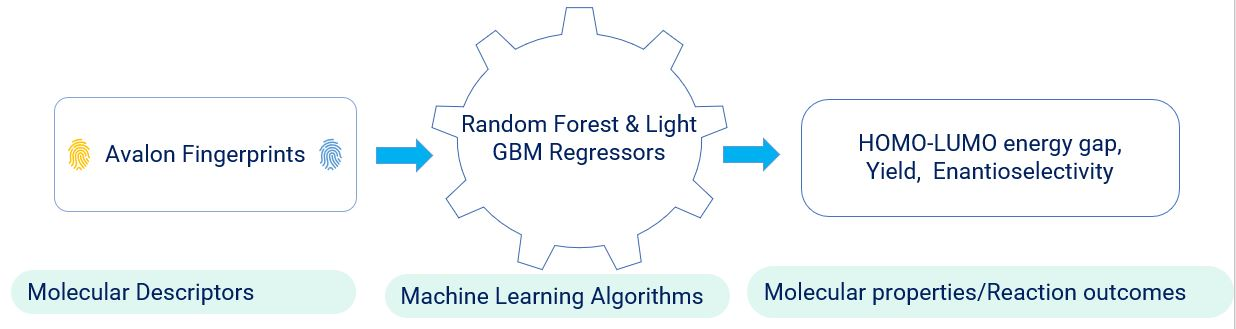
    <p>
      <b>Fig 1</b> Avalon Fingerprints for predictive modeling schematic. <b><sup>1</sup></b>
    </p>
</div>

The dataset **<sup>2</sup>** we will use consists of molecular SMILES strings and HOMO-LUMO energy gap (meV) of around 2,900 small organic molecules. It is from the work by *Sandford et al.* **<sup>3</sup>**, which the work in this notebook is based on.

In the work by *Sandfort et al.*, which utilises an **array of molecular fingerprints (multiple fingerprint features)**, as well as **individual molecular fingerprints (single fingerprint features)** to be used in **multivariate linear regression (MLR)** models to identify **linear free energy relationships** for **reaction prediction**.

The fingerprints *Sandfort et al.* use include:
* **Avalon Fingerprint** (3096 bits)
* **Atom-Pairs Fingerprint** (3096 bits)
* **Topological-Torsions Fingerprint** (3096 bits)
* **MACCS-keys Fingerprint** (167 bits)
* **RDKit Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **RDKit linear Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **RDKit layered Fingerprint**, radii 2, 4, 6, 8 (3096 bits)
* **Morgan-Circular Fingerprint**, radii 0, 2, 4, 6 (3096 bits)
* **Morgan-Circular Fingerprint with feature definitions**, radii 0, 2, 4, 6 (3096 bits)

Interestingly, in the results and discussion, *Sandfort et al.* report that for the prediction of HOMO-LUMO energy gaps, the **Avalon fingerprint is the most suitable single fingerprint** for training the machine learning model. 

However for C-N cross-coupling reaction yield predictions and prediction of enantioselectivities, there was **no clear single most suitable fingerprint**. 

Therefore, the **multiple fingerprint feature model was used exclusively for all studies in the paper**.

<div align="center">
    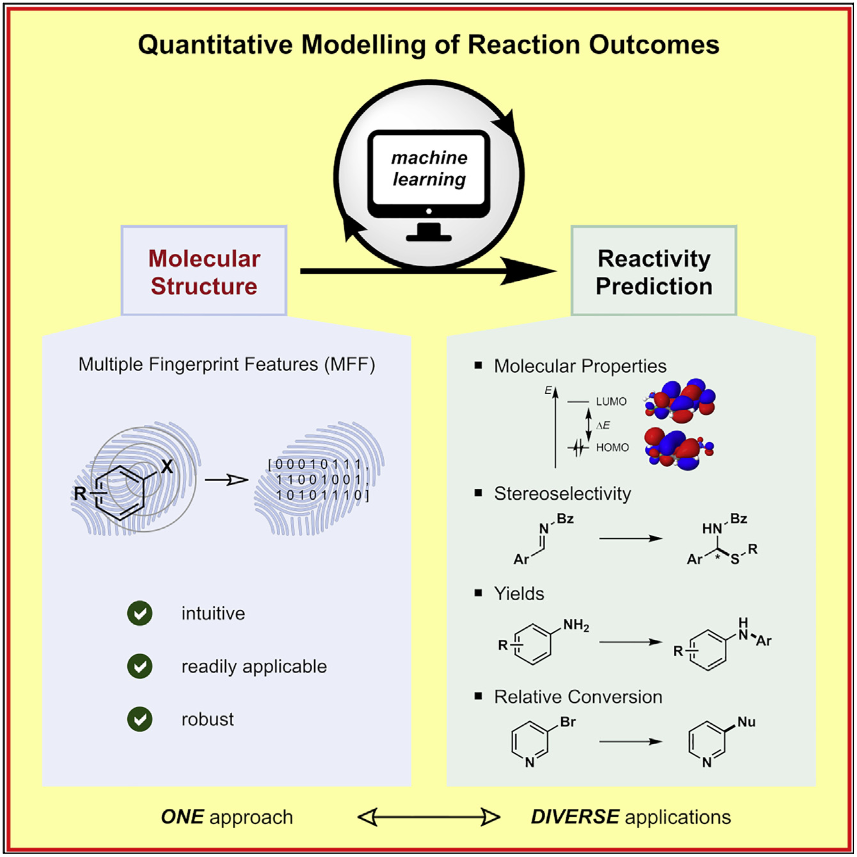
    <p>
      <b>Fig 2</b> A structure-based platform for predicting chemical reactivity by <i>Sandfort et al.</i> <b><sup>3</sup></b>
    </p>
</div>

In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#-------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
#-------------------------------------------------------
from lightgbm import LGBMRegressor
from typing import List, Dict
#-------------------------------------------------------
os.environ['SUP_LEARN_PYTHON_DIR_PATH'] =  os.path.join(os.getcwd(), '../src')
os.environ['SUP_LEARN_DATA_DIR_PATH'] =  os.path.join(os.getcwd(), '../data')
sys.path.append(os.getenv('SUP_LEARN_PYTHON_DIR_PATH'))
sys.path.append(os.getenv('SUP_LEARN_DATA_DIR_PATH'))

from utils import avalon_fingerprints_utils

# 2. Reactivity Prediction: HOMO-LUMO Energy Gap of Organic Molecules

The HOMO-LUMO energy gap for the 2,900 small organic molecules in the dataset were obtained from **DFT calculations** (**Fig 3**). The small organic molecules in the dataset came from the *Sandfort et al.* group's inventory.

Current machine learning models for the **quantitative modelling of reaction outcomes based on DFT-calculate descriptors** require molecules that have **at least one structural motif, atom or functional group in common**. **<sup>3</sup>**

The goal of *Sandfort et al.* on the other hand, was to develop a model **applicable to a variety of organic chemical prediction problems**. HOMO-LUMO energy gap prediction is particularly useful in this context as it is a **property of the overall molecule**, and so a model trained on such data will represent and compare not only local substructures of a molecule, but also **global molecular characteristics**. **<sup>3</sup>**

<div align="center">
    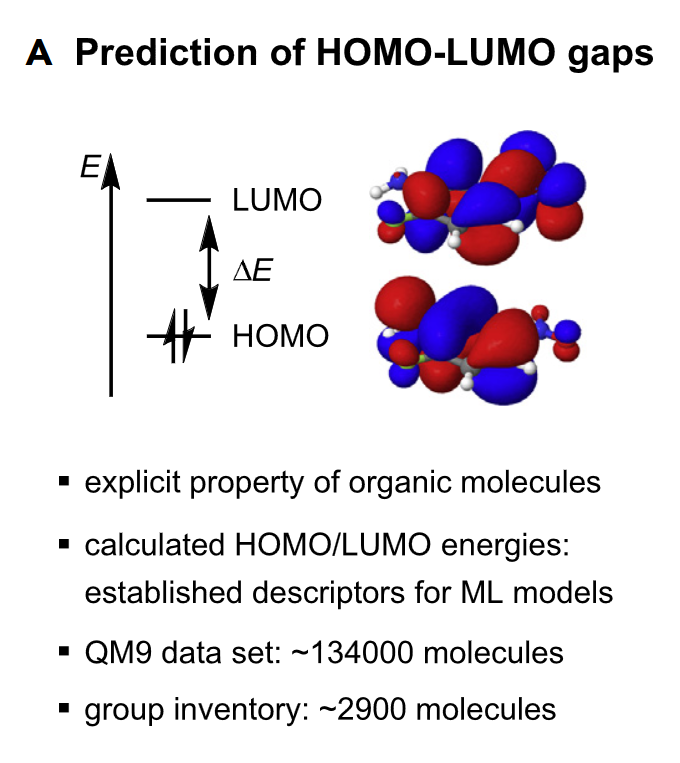
    <p>
      <b>Fig 2</b> Calculated HOMO-LUMO energy gaps as an explicit molecular property by <i>Sandfort et al.</i> <b><sup>3</sup></b> (2-Fluoro-5-nitroaniline calculated HOMO-LUMO geometries shown).
    </p>
</div>

## 2.1 Data Preparation

In [2]:
# Load data
homo_lumo_dataset: pd.DataFrame = pd.read_csv(
    os.path.join(
        os.getenv('SUP_LEARN_DATA_DIR_PATH'), 
        'raw/orbital-energies-input-data.csv'
    )
)

# Add 2D structure columnd
PandasTools.AddMoleculeColumnToFrame(
    homo_lumo_dataset,
    'SMILES',
    'Structure',
    includeFingerprints=True
)

# Generate Avalon fingerprints
avalon_fpts: np.ndarray = avalon_fingerprints_utils.generate_avalon_fingerprints(
    homo_lumo_dataset['Structure']
)

# Insert into DataFrame. Each row represents a molecule's Avalon fingerprint and
# each column an individual bit
avalon_fpts_dataset: pd.DataFrame = pd.DataFrame(
    avalon_fpts,
    columns=['Bit_{}'.format(bit) for bit in range(avalon_fpts.shape[1])]
)

avalon_fpts_dataset.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2904/2904 [00:00<00:00, 4034.80it/s]


,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_4086,Bit_4087,Bit_4088,Bit_4089,Bit_4090,Bit_4091,Bit_4092,Bit_4093,Bit_4094,Bit_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Instantiate and Train Models

We will now **instantiate and train our models** on the Avalon fingerprint dataset.

### 2.2.1 LightGBM Regressor (`LGBMRegressor`)

LightGBM, which stands for **Light Gradient Boosting Machine**, is a **highly efficient and fast implementation of gradient boosting for decision tree algorithms**.
* **Gradient Boosting** is a powerful machine learning technique used for **both regression and classification tasks**.
* **It builds an ensemble of trees** in a **sequential manner**, where each new tree is **trained to correct the errors of the previous trees**.
* This is in contrast to **bagging-based algorithms** such as **Random Forest**, where the trees in the ensemble are **built independently and combined**.
* It **combines the predictions of multiple weaker learners** to create a **strong learner predictive model**.
* Gradient boosting uses **gradient descent to minimise loss function loss** (*c.f.* `intro_to_supervised_learning.ipynb`). Each new tree is **fit on the negative gradient of the loss function** with respect to the **predictions of the previously built ensemble of trees**.

LightGBM has the following key characteristics:
1. **Speed and Efficiency**: LightGBM is **optimised for performance and memory usage**, making it **much faster than other gradient boosting implementations**.
2. **Support for large datasets**: LightGBM can **handle large-scale data** with **millions of instances and features** efficiently.
3. **Accuracy**: It provides **high accuracy** due to the implementation of advanced features like **leaf-wise tree growth** (uses the leaf with the **maximum reduction in loss to be split next**.

The **`LGBMRegressor`** class in the **LightGBM library** is **designed specifically for regression tasks**. It inherits from LightGBM's core functionalities and allows for the building of **powerful regression models**.

### 2.2.2 Random Forest Regressor (`RandomForestRegressor`)

The class `RandomForestRegressor` is a **popular ensemble supervised learning method** from the **scikit-learn library**. It is used for **regression tasks** and, like LightGBM regressor, **combines the predictions of multiple weaker learners** to create a **strong learner predictive model**.

However, it differs from LightGBM regressor in that it utilises the technique called **bagging** where the **predictions of the individual trees are aggregated through averaging to give a final, stronger prediction**.

In [3]:
# Instantiate the `LGBMRegressor` model. The `n_estimators` argument specifies the number of boosting
# iteratinos (i.e. the number of trees in the model). The `random_state` argument sets the seed for the
# random number generator, ensuring the results are reproducible (i.e. that the same random sequences are
# generated each time the code is run)
lgbm_regressor: LGBMRegressor = LGBMRegressor(n_estimators=800, random_state=42)

# Instantiate the `RandomForestRegressor`model. The `random_state` argument sets the seed for the random 
# number generator, ensuring the results are reproducible 
rf_regressor: RandomForestRegressor = RandomForestRegressor(random_state=42)

## 2.3 10-Fold Cross-Validation of Avalon Fingerprints

In [4]:
# Start timer to calculate total execution time
start_time = time.time()

# Create a cross-validator that randomly shuffles and splits data into training and test sets
# `n_splits=10` specifies that 10 splits should be created. This is the 10-fold cross-validation
# `test_sizer-0.3` specifies that 30% of the data should be used as the test set for each split
# `randdm_state=42` specifies the random seed to ensure reproducibility
cross_validator = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

# Define scoring metrics. 
# Metric `r2` is the coefficient of determination, which measures the proportion of variance explained by the model
# Metric `neg_mean_absolute_error` is the negative mean absolute error, measuring the average absolute errors
# between the predicted and actual values
scoring_metrics: List[str] = ['r2', 'neg_mean_absolute_error']

# Cross-validation execution.
cross_validation_scores: Dict = cross_validate(
    lgbm_regressor, # The LightGBM model to evaluate
    avalon_fpts_dataset, # The feature matrix
    homo_lumo_dataset.Energygap, # The target variable
    scoring=scoring_metrics, # The list of metrics to evaluate
    cv=cross_validator # The cross-validator
)

print(cross_validation_scores)

end_time = time.time()
execution_time = end_time - start_time
print('\n Cross-validation execution time: ', round(execution_time/60, 2), 'min')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1031
[LightGBM] [Info] Start training from score 190.942365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [5]:
# Output coefficient of determination (R²) of 10-fold cross-validation
cross_validation_scores['test_r2']

array([0.91044654, 0.90800796, 0.91153183, 0.92018218, 0.9045963 ,
       0.89865031, 0.90671041, 0.90788038, 0.89827042, 0.91485459])

In [6]:
# Output mean absolute error (MAE) of 10-fold cross-validation (negative of negative  mean absolute error)
-cross_validation_scores['test_neg_mean_absolute_error']

array([5.79133628, 5.82072238, 5.86919926, 5.52286442, 6.21463951,
       6.16613145, 5.97132058, 6.12992087, 5.94971449, 5.76417806])

In [7]:
# Output mean values of R² and MAE for 10-fold cross-validation using LightGBM
print('Cross-Validation R²: ', round(np.mean(cross_validation_scores['test_r2']), 2), '\n')
print('Cross-Validation Mean Absolute Error: ', round(np.mean(-cross_validation_scores['test_neg_mean_absolute_error']), 2))

Cross-Validation R²:  0.91 

Cross-Validation Mean Absolute Error:  5.92


Below we can see a comparison from the model performance evaluation in the paper by *Sandford et al.* **<sup>3</sup>** We are using the research group's inventory dataset. 

Although *Sandford et al.* is using a **multiple fingerprint feature model** (i.e. more than one molecular fingerprint), the $R^2$ and mean absolute error of our cross-validation **is comparable**

<div align="center">
        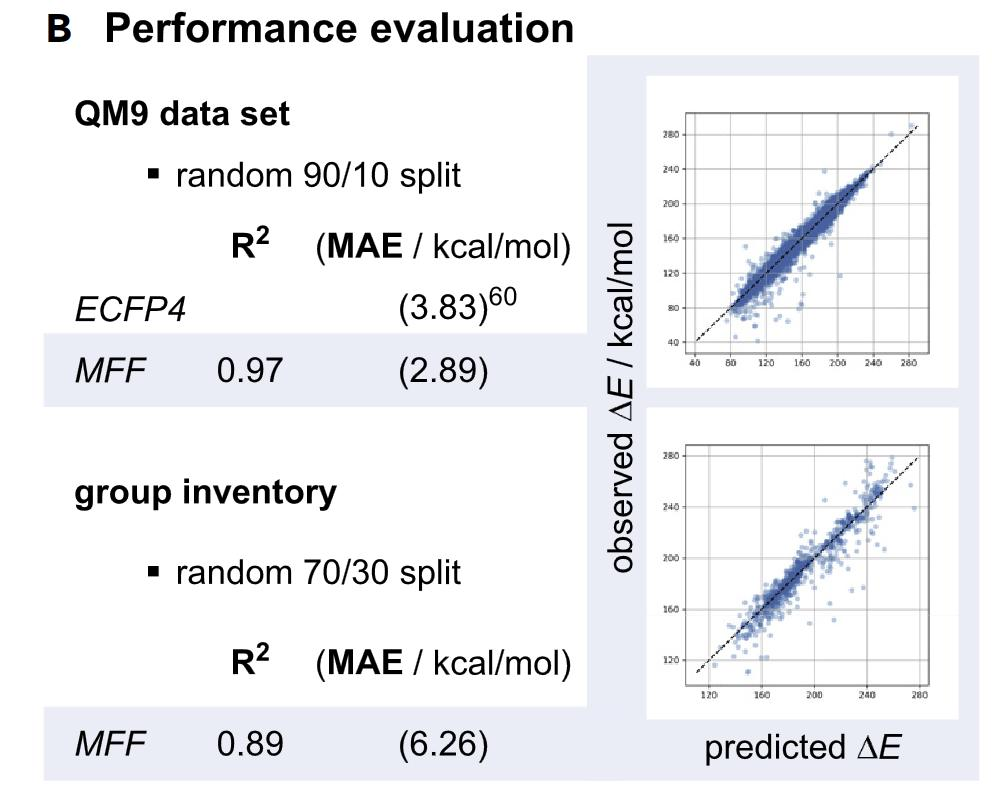
        <p>
          <b>Fig 3</b> Performance evaluation of the multiple fingerprint feature model on the QM9 dataset and the research group's inventory dataset by <i>Sandfort et al.</i> <b><sup>3</sup></b>
        </p>
      </div>

## 2.4 Avalon Fingerprint Train Data-Test Split and Training Model

In [8]:
# Split data into training and test sets using `train_test_split()` function
# `ava_homo_lumo_x_train` and `ava_homo_lumo_x_test` are the feature matrices for training and testing (Avalon fingerprints)
# `ava_homo_lumo_y_train` and `ava_homo_lumo_y_test` are the target vectors for training and testing (HOMO-LUMO energy gap)
ava_homo_lumo_x_train, ava_homo_lumo_x_test, ava_homo_lumo_y_train, ava_homo_lumo_y_test = train_test_split(
    avalon_fpts_dataset, # The feature matrix (Avalon fingerprints)
    homo_lumo_dataset.Energygap, # The target variable (HOMO-LUMO energy gap)
    test_size=0.3, # 30% of the data is reserved for testing, and 70% is used for training
    random_state=42 # Random number generator seed
)

# LightGBM model training
ava_homo_lumo_lgbm_model = lgbm_regressor.fit(
    ava_homo_lumo_x_train, # Training feature matrix (Avalon fingerprints)
    ava_homo_lumo_y_train # Training target vector (HOMO-LUMO energy gap)
)

# Test trained LightGBM model using testing feature matrix (Avalon fingerprints)
# Outputs a predicted target vector (predicted HOMO-LUMO energy gap)
ava_homo_lumo_lgbm_model_predict = ava_homo_lumo_lgbm_model.predict(ava_homo_lumo_x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642


In [9]:
# Measure model performance by calculating mean average error (MAE) between actual and predicted HOMO-LUMO gap values
ava_homo_lumo_predict_mae = mean_absolute_error(ava_homo_lumo_y_test, ava_homo_lumo_lgbm_model_predict)
print(
    '\n Avalon HOMO LUMO LightGBM Model Prediction Mean Average Error: ', 
    round(ava_homo_lumo_predict_mae, 2)
)


 Avalon HOMO LUMO LightGBM Model Prediction Mean Average Error:  5.79


In [10]:
# Measure model performance with coefficient of determination (R²) score between actual and predicted HOMO-LUMO gap values
ava_homo_lumo_predict_r2 = r2_score(ava_homo_lumo_y_test, ava_homo_lumo_lgbm_model_predict)
print(
    '\n Avalon HOMO LUMO LightGBM Model Prediction R²: ', 
    round(ava_homo_lumo_predict_r2, 2)
)


 Avalon HOMO LUMO LightGBM Model Prediction R²:  0.91


Text(0.05, 0.95, 'R² = 0.91\nMAE (kcal/mol) = 5.79')

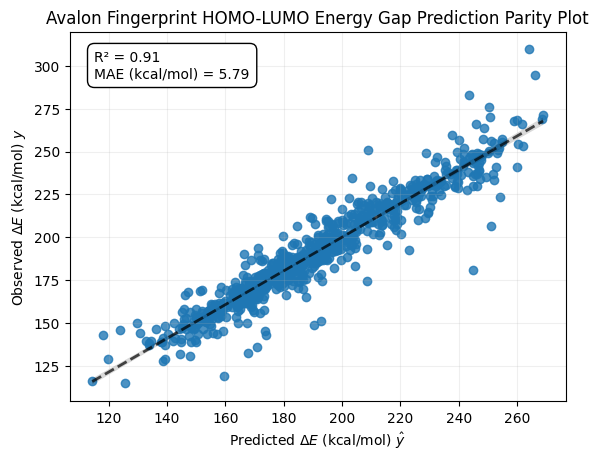

In [11]:
# Avalon Fingerprints HOMO-LUMO Energy Gap Prediction Parity Plot
sns.regplot(
    x=ava_homo_lumo_lgbm_model_predict, 
    y=ava_homo_lumo_y_test,
    line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel(r"Predicted $\Delta E$ (kcal/mol) $\hat{y}$")
plt.ylabel(r"Observed $\Delta E$ (kcal/mol) $y$")
plt.title("Avalon Fingerprint HOMO-LUMO Energy Gap Prediction Parity Plot")
plt.grid(alpha=0.2)

ava_homo_lumo_predict_label_text = f"R² = {ava_homo_lumo_predict_r2:.2f}\nMAE (kcal/mol) = {ava_homo_lumo_predict_mae:.2f}"
plt.text(0.05, 0.95, ava_homo_lumo_predict_label_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(facecolor='white', boxstyle='round,pad=0.5'))

# 3. Reactivity Prediction: Yield for C-N Cross-Coupling Reactions

# 4. Reactivity Prediction: Catalytic Enantioselectivity of Thiol-Imine Reactions

# 5. References

**[1]** Goshu, G.M. (2023) Avalon-fingerprints-for-machine-learning/avalon fingerprints for predictive modeling.ipynb at main · GASHAWMG/Avalon-fingerprints-for-machine-learning, *GitHub*. Available at: https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Avalon%20fingerprints%20for%20predictive%20modeling.ipynb (Accessed: 10 July 2024).<br><br>
**[2]** Kühnemund, M. (2020) Marius Kühnemund / FP-DM-tool · GitLab, *GitLab*. Available at: https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool (Accessed: 10 July 2024).<br><br>
**[3]** Sandfort, F. et al. (2020) ‘A structure-based platform for predicting chemical reactivity’, *Chem*, 6(6), pp. 1379–1390. <br><br>